In [168]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchview import draw_graph

from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
    save_text_output,
)
from src.utils.load_data import load_data

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [169]:
# 真値パラメータ（すべてのデータセットで共通）
L_true: float = 223.6e-6
C_true: float = 73.8e-6
R_true: float = 5

Vin: float = 10
Vref: float = 5
duty: float = Vref / Vin
f_sw: float = 1e5  # スイッチング周波数
T: float = 1 / f_sw  # 1周期の実時間
points_per_cycle: int = 200  # 1周期あたりのプロット数
cycles: int = 1000  # 周期数


# 学習に使うデータの長さ
tail_len = points_per_cycle * 10
train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000


In [170]:
# 実験設定を辞書としてまとめる（重複検出用）
config_dict = {
    "L_true": L_true,
    "C_true": C_true,
    "R_true": R_true,
    "Vin": Vin,
    "Vref": Vref,
    "f_sw": f_sw,
    "points_per_cycle": points_per_cycle,
    "cycles": cycles,
    "tail_len": tail_len,
    "train_ratio": train_ratio,
    "valid_ratio": valid_ratio,
    "L_init": L_init,
    "C_init": C_init,
    "R_init": R_init,
    "lr_L": lr_L,
    "lr_C": lr_C,
    "lr_R": lr_R,
    "epochs": epochs,
}

# ログ保存の初期化
result_dir = create_result_dir("note17", config_dict=config_dict)
log_path = init_log(result_dir, "notebooks/note17.ipynb")
print(f"ログ保存先: {result_dir}/log.md")

ログ保存先: /Users/otsukanaoya/Desktop/unilab/rnn-pann/results/20251224_154711_621_note17/log.md


In [171]:
class BuckConverterCell(nn.Module):
    def __init__(self, L_init: float, C_init: float, R_init: float) -> None:
        super().__init__()
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(self, h: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        h: [iL, vC]
        x: [vs, u, dt]
        """

        iL = h[:, 0]
        vC = h[:, 1]
        vs = x[:, 0]
        u = x[:, 1]
        dt = x[:, 2]
        vp = vs * u

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # オイラー法
        iL_next = iL + (dt / L) * (vp - vC)
        vC_next = vC + (dt / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1)


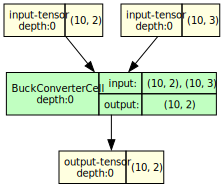

'tmp/model_graph_torchview.png'

In [172]:
model = BuckConverterCell(L_init=1, C_init=1, R_init=1)

# ダミーデータを作成
dummy_time_step = 10
h_dummy = torch.randn(dummy_time_step, 2)
x_dummy = torch.randn(dummy_time_step, 3)

model_graph = draw_graph(
    model,
    input_data=[h_dummy, x_dummy],
    expand_nested=True,
)
display(model_graph.visual_graph)

model_graph.visual_graph.render(
    filename="tmp/model_graph_torchview",
    format="png",
)

# ~~BuckConverterCell を使ってシミュレーションデータを作成~~

csvに保存したシミュレーションデータを学習データとする

In [ ]:
t_raw, iL_raw, vC_raw = load_data(
    path="../data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc2000_cyc1000/buck_sim_Vin10.0_Vref5.0_fs100000.csv",
    skiprows=0,
    downsample_step=1,  # ダウンスケールしない
    T=T,
    cycles=10,
    start_time_offset=0,
    time_label="t",
    iL_label="iL",
    vC_label="vC",
)
downsample_step = len(t_raw) // (points_per_cycle * 10)
t: np.ndarray = t_raw[::downsample_step]
iL: torch.Tensor = torch.tensor(iL_raw[::downsample_step], dtype=torch.float32)
vC: torch.Tensor = torch.tensor(vC_raw[::downsample_step], dtype=torch.float32)
print(f"{t.shape=}")

t.shape=(2000,)


len(t)=2000
len(dt)=1999
len(u)=1999
len(vs)=1999


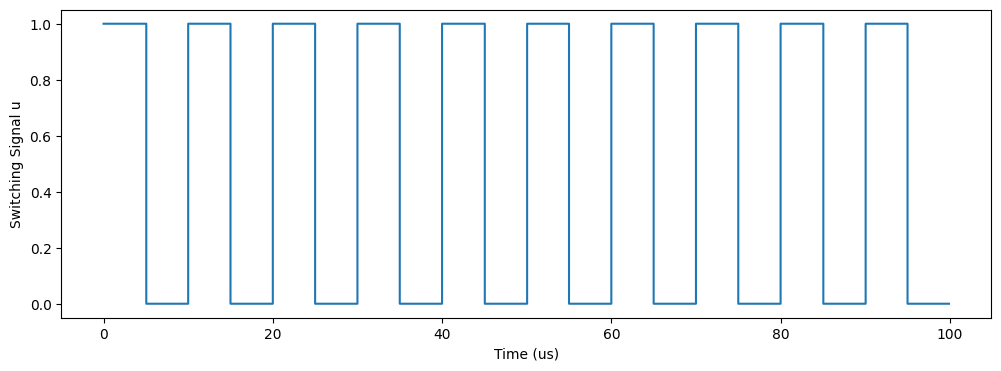

In [174]:
dt: np.ndarray = np.diff(t)

# スイッチング信号
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

print(f"{len(t)=}")
print(f"{len(dt)=}")
print(f"{len(u)=}")
print(f"{len(vs)=}")

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u")
plt.show()

In [175]:
# # モデルを作成
# model_true = BuckConverterCell(L_init=L_true, C_init=C_true, R_init=R_true)

# # numpy配列をテンソルに変換（dtをxに含める）
# x_tensor = torch.tensor(np.c_[vs, u, dt], dtype=torch.float32)

# il_list = []
# vc_list = []

# # シミュレーション実行
# with torch.no_grad():
#     h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
#     il_list.append(h_current[0, 0].item())  # i_L
#     vc_list.append(h_current[0, 1].item())  # v_C

#     for j in range(len(t) - 1):
#         h_current = model_true(h_current, x_tensor[j : j + 1])

#         il_list.append(h_current[0, 0].item())  # i_L
#         vc_list.append(h_current[0, 1].item())  # v_C


# iL = torch.tensor(np.array(il_list), dtype=torch.float32)
# vC = torch.tensor(np.array(vc_list), dtype=torch.float32)

# print(iL.shape)
# print(vC.shape)


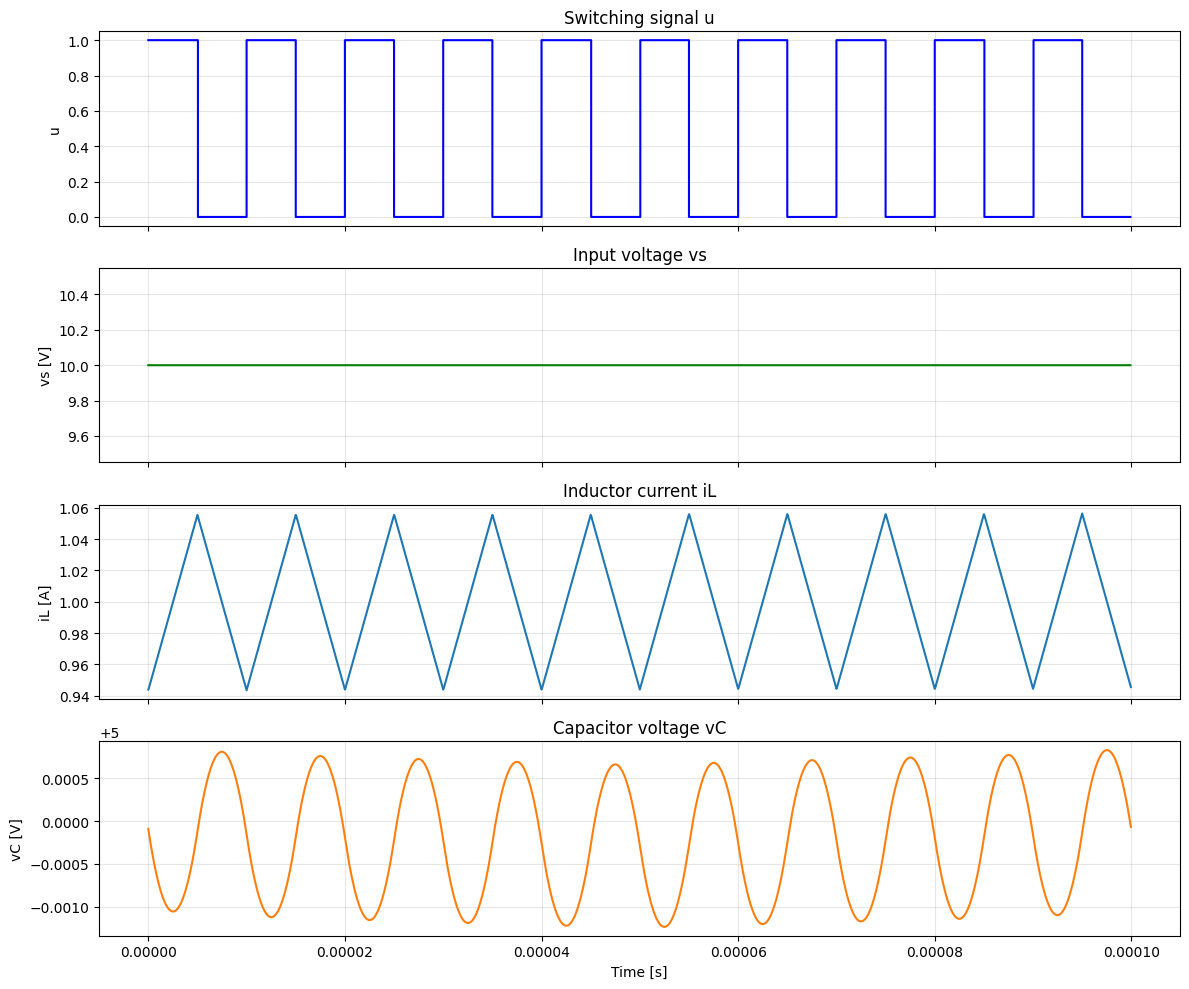

In [176]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t[:-1], u, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u")
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Switching signal u")

# 2: vs (input voltage)
axs[1].plot(t[:-1], vs, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]")
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Input voltage vs")

# 3: iL (inductor current)
axs[2].plot(t, iL, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]")
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Inductor current iL")

# 4: vC (capacitor voltage)
axs[3].plot(t, vC, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]")
axs[3].set_xlabel("Time [s]")
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Capacitor voltage vC")

plt.tight_layout()
plt.show()


# 前処理


In [177]:
# 定常の10周期分
t_10 = t[-tail_len - 1 :]
dt_10 = dt[-tail_len:]
u_10 = u[-tail_len:]
vs_10 = vs[-tail_len:]
iL_10 = iL[-tail_len - 1 :]
vC_10 = vC[-tail_len - 1 :]

# numpy配列をテンソルに変換
dt_10_tensor = torch.tensor(dt_10, dtype=torch.float32)
u_10_tensor = torch.tensor(u_10, dtype=torch.float32)
vs_10_tensor = torch.tensor(vs_10, dtype=torch.float32)

# train
train_len = int(len(dt_10) * train_ratio)

t_train = t_10[: train_len + 1]
dt_train = dt_10_tensor[:train_len]
u_train = u_10_tensor[:train_len]
vs_train = vs_10_tensor[:train_len]
iL_train = iL_10[: train_len + 1]
vC_train = vC_10[: train_len + 1]

h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)


# valid
valid_len = int(len(t_10) * valid_ratio)

t_valid = t_10[train_len : train_len + valid_len]
dt_valid = dt_10_tensor[train_len : train_len + valid_len]
u_valid = u_10_tensor[train_len : train_len + valid_len]
vs_valid = vs_10_tensor[train_len : train_len + valid_len]
iL_valid = iL_10[train_len : train_len + valid_len + 1]
vC_valid = vC_10[train_len : train_len + valid_len + 1]

h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

# test
t_test = t_10[train_len + valid_len :]
dt_test = dt_10_tensor[train_len + valid_len :]
u_test = u_10_tensor[train_len + valid_len :]
vs_test = vs_10_tensor[train_len + valid_len :]
iL_test = iL_10[train_len + valid_len :]
vC_test = vC_10[train_len + valid_len :]

h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)


print(f"{h_train.shape=}")
print(f"{x_train.shape=}")
print(f"{dt_train.shape=}")
print(f"{target_train.shape=}")

print(f"{h_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{dt_valid.shape=}")
print(f"{target_valid.shape=}")

print(f"{h_test.shape=}")
print(f"{x_test.shape=}")
print(f"{dt_test.shape=}")
print(f"{target_test.shape=}")


h_train.shape=torch.Size([599, 2])
x_train.shape=torch.Size([599, 3])
dt_train.shape=torch.Size([599])
target_train.shape=torch.Size([599, 2])
h_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
dt_valid.shape=torch.Size([600])
target_valid.shape=torch.Size([600, 2])
h_test.shape=torch.Size([800, 2])
x_test.shape=torch.Size([800, 3])
dt_test.shape=torch.Size([800])
target_test.shape=torch.Size([800, 2])


# 学習


In [178]:
model = BuckConverterCell(L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    model.train()
    optimizer.zero_grad()
    h_pred_train = model(h_train, x_train)
    train_loss = loss_fn(h_pred_train, target_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    model.eval()
    with torch.no_grad():
        h_pred_valid = model(h_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(model.log_L.exp().item())
    param_history["C"].append(model.log_C.exp().item())
    param_history["R"].append(model.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}  "
            f"L={model.log_L.exp().item() * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={model.log_C.exp().item() * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={model.log_R.exp().item():.2f}Ω (true={R_true:.1f})"
        )
        print(output_line)


Epoch 0: Train Loss=3.203791e-08, Valid Loss=2.731936e-08  L=209.7µH (true=223.6)  C=100.8µF (true=73.8)  R=7.86Ω (true=5.0)
Epoch 50: Train Loss=4.951194e-09, Valid Loss=7.603817e-09  L=224.1µH (true=223.6)  C=118.3µF (true=73.8)  R=4.84Ω (true=5.0)
Epoch 100: Train Loss=4.853442e-09, Valid Loss=7.493717e-09  L=224.9µH (true=223.6)  C=118.4µF (true=73.8)  R=5.00Ω (true=5.0)
Epoch 150: Train Loss=4.853169e-09, Valid Loss=7.491608e-09  L=225.0µH (true=223.6)  C=118.0µF (true=73.8)  R=5.00Ω (true=5.0)
Epoch 200: Train Loss=4.852823e-09, Valid Loss=7.491663e-09  L=225.0µH (true=223.6)  C=117.6µF (true=73.8)  R=5.00Ω (true=5.0)
Epoch 250: Train Loss=4.852106e-09, Valid Loss=7.491030e-09  L=225.0µH (true=223.6)  C=117.2µF (true=73.8)  R=5.00Ω (true=5.0)
Epoch 300: Train Loss=4.851149e-09, Valid Loss=7.490632e-09  L=225.0µH (true=223.6)  C=116.7µF (true=73.8)  R=5.00Ω (true=5.0)
Epoch 350: Train Loss=4.850813e-09, Valid Loss=7.490054e-09  L=225.0µH (true=223.6)  C=116.3µF (true=73.8)  R=5.00

# 結果


In [179]:
# テストデータでの評価
model.eval()
with torch.no_grad():
    h_pred_test = model(h_test, x_test)
    test_loss = loss_fn(h_pred_test, target_test)

print(f"Final test loss: {test_loss.item():.6e}")


Final test loss: 5.746588e-09


In [180]:
final_train_loss = loss_history["train"][-1]
final_valid_loss = loss_history["valid"][-1]
final_test_loss = test_loss.item()

final_L = param_history["L"][-1]
final_C = param_history["C"][-1]
final_R = param_history["R"][-1]

# 実験設定の表示
result_text = []
result_text.append("=" * 60)
result_text.append("")
result_text.append("【回路パラメータ】")
result_text.append(
    f"  真の値: L = {L_true:.6e} [H], C = {C_true:.6e} [F], R = {R_true:.3f} [Ω]"
)
result_text.append(
    f"  初期値: L = {L_init:.6e} [H], C = {C_init:.6e} [F], R = {R_init:.3f} [Ω]"
)
result_text.append(
    f"  推論値: L = {final_L:.6e} [H], C = {final_C:.6e} [F], R = {final_R:.3f} [Ω]"
)
result_text.append("")
result_text.append("【入力条件】")
result_text.append(
    f"  Vin (入力電圧) = {Vin:.2f} [V], Vref (目標電圧) = {Vref:.2f} [V]"
)
result_text.append(f"  スイッチング周波数 f_sw = {f_sw:.0f} [Hz]")
result_text.append(f"  1周期あたりのプロット数 = {points_per_cycle}")
result_text.append("")
result_text.append("【データ分割】")
result_text.append(f"  シミュレーション時間: {cycles}周期 = {cycles * T * 1e6:.1f}μs")
result_text.append(
    f"  後ろから約{int(tail_len / points_per_cycle)}周期"
    f"({tail_len}ステップ, ={tail_len * dt_10.mean() * 1e6:.1f}μs)を使用"
)
result_text.append(f"  学習データ: {train_len} ステップ")
result_text.append(f"  検証データ: {valid_len} ステップ")
result_text.append(f"  テストデータ: {len(t_10) - train_len - valid_len} ステップ")
result_text.append("")
result_text.append("【最終Loss】")
result_text.append(f"  学習データ: {final_train_loss:.6e}")
result_text.append(f"  検証データ: {final_valid_loss:.6e}")
result_text.append(f"  テストデータ: {final_test_loss:.6e}")
result_text.append("")
result_text.append("【学習設定】")
result_text.append(f"  エポック数: {epochs}")
result_text.append(f"  学習率: L = {lr_L:.2e}, C = {lr_C:.2e}, R = {lr_R:.2e}")

result_output = "\n".join(result_text)
print(result_output)

# 結果をログに保存
save_text_output(result_dir, result_output, "最終結果")



【回路パラメータ】
  真の値: L = 2.236000e-04 [H], C = 7.380000e-05 [F], R = 5.000 [Ω]
  初期値: L = 2.000000e-04 [H], C = 1.000000e-04 [F], R = 8.000 [Ω]
  推論値: L = 2.249571e-04 [H], C = 1.101332e-04 [F], R = 4.999 [Ω]

【入力条件】
  Vin (入力電圧) = 10.00 [V], Vref (目標電圧) = 5.00 [V]
  スイッチング周波数 f_sw = 100000 [Hz]
  1周期あたりのプロット数 = 200

【データ分割】
  シミュレーション時間: 1000周期 = 10000.0μs
  後ろから約10周期(2000ステップ, =100.0μs)を使用
  学習データ: 599 ステップ
  検証データ: 600 ステップ
  テストデータ: 801 ステップ

【最終Loss】
  学習データ: 4.845465e-09
  検証データ: 7.484348e-09
  テストデータ: 5.746588e-09

【学習設定】
  エポック数: 1000
  学習率: L = 5.00e-02, C = 1.00e-02, R = 2.00e-02


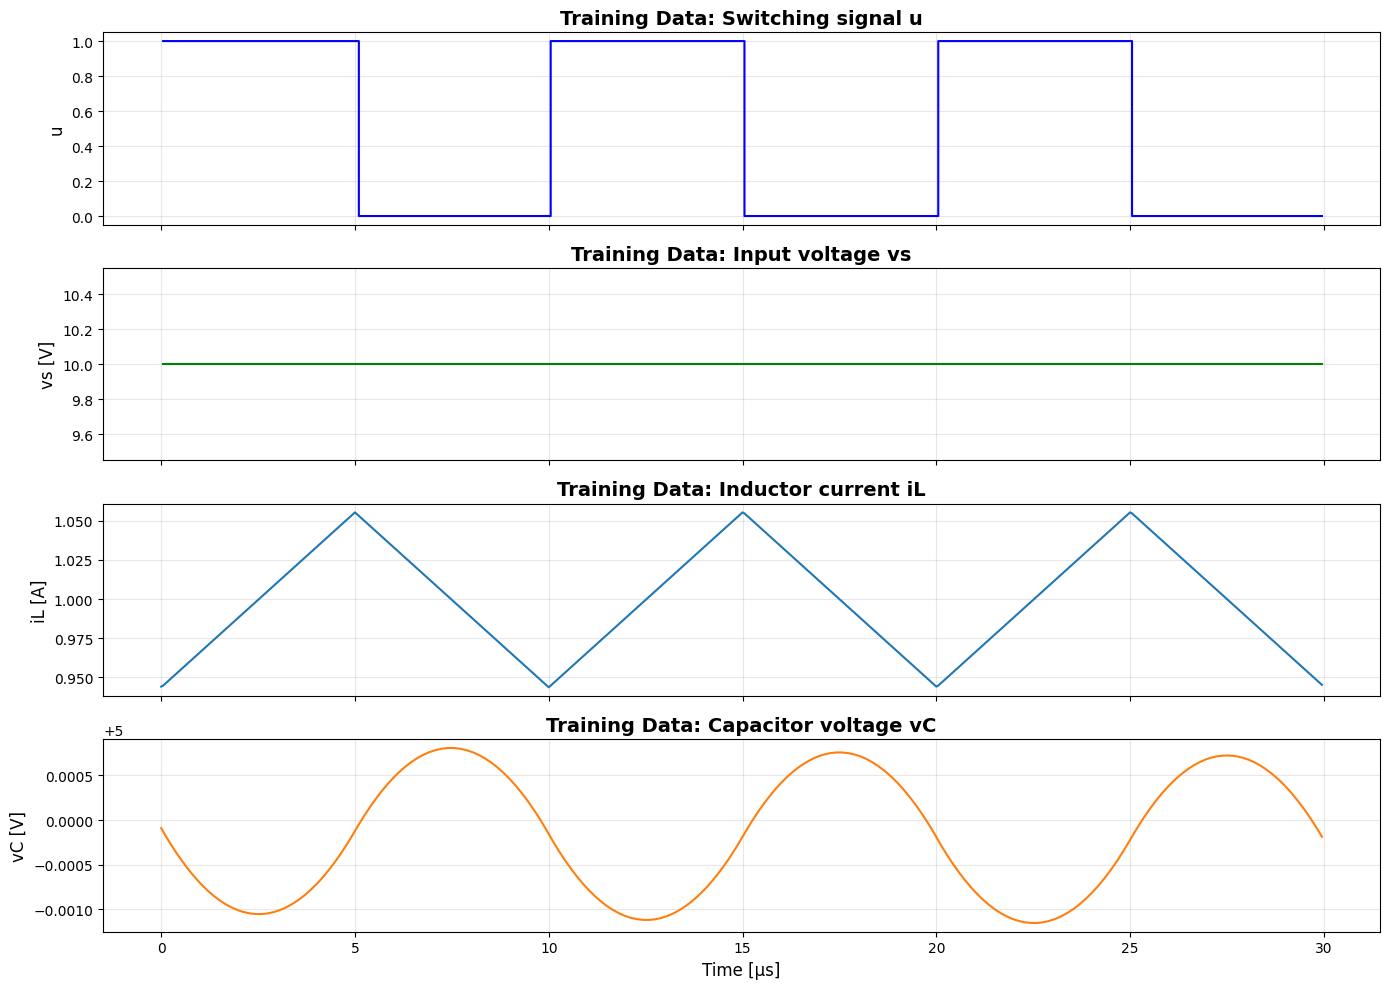

In [181]:
# 学習に使ったデータ
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t_train[1:] * 1e6, u_train, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u", fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Training Data: Switching signal u", fontsize=14, fontweight="bold")

# 2: vs (input voltage)
axs[1].plot(t_train[1:] * 1e6, vs_train, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]", fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Training Data: Input voltage vs", fontsize=14, fontweight="bold")

# 3: iL (inductor current)
axs[2].plot(t_train * 1e6, iL_train, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]", fontsize=12)
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Training Data: Inductor current iL", fontsize=14, fontweight="bold")

# 4: vC (capacitor voltage)
axs[3].plot(t_train * 1e6, vC_train, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]", fontsize=12)
axs[3].set_xlabel("Time [μs]", fontsize=12)
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Training Data: Capacitor voltage vC", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# 画像をログに保存
save_figure_to_log(fig, "training_data", result_dir, "学習データ")


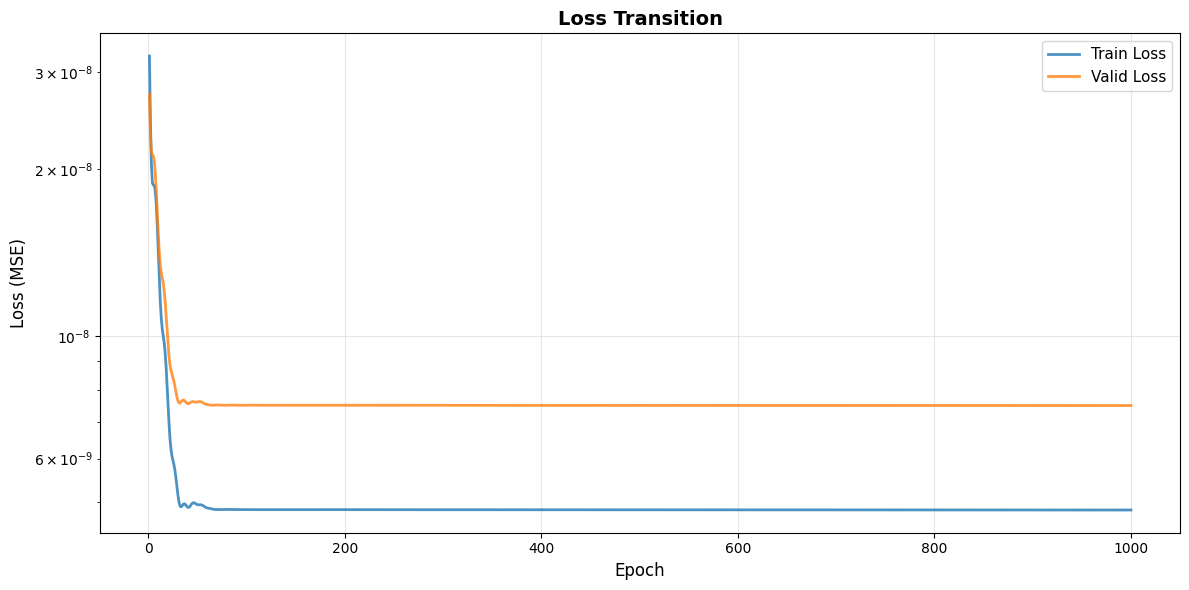

In [182]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
save_figure_to_log(fig, "loss_transition", result_dir, "Lossの遷移")


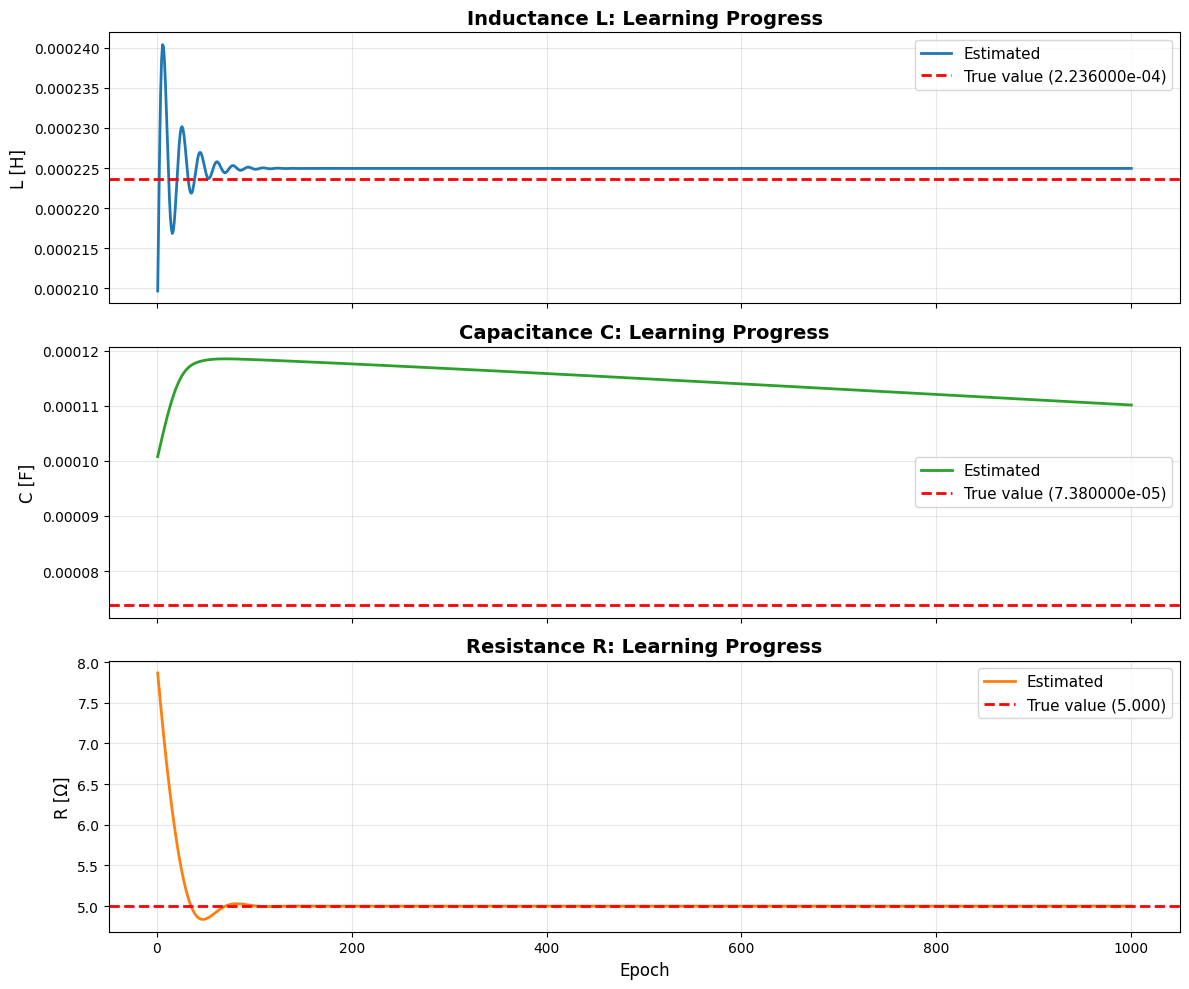

In [183]:
# 回路パラメータの学習による変化をグラフ表示
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

epochs_list = range(1, epochs + 1)

# Lの変化
axs[0].plot(
    epochs_list, param_history["L"], label="Estimated", linewidth=2, color="tab:blue"
)
axs[0].axhline(
    y=L_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({L_true:.6e})",
)
axs[0].set_ylabel("L [H]", fontsize=12)
axs[0].set_title("Inductance L: Learning Progress", fontsize=14, fontweight="bold")
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# Cの変化
axs[1].plot(
    epochs_list, param_history["C"], label="Estimated", linewidth=2, color="tab:green"
)
axs[1].axhline(
    y=C_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({C_true:.6e})",
)
axs[1].set_ylabel("C [F]", fontsize=12)
axs[1].set_title("Capacitance C: Learning Progress", fontsize=14, fontweight="bold")
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

# Rの変化
axs[2].plot(
    epochs_list, param_history["R"], label="Estimated", linewidth=2, color="tab:orange"
)
axs[2].axhline(
    y=R_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({R_true:.3f})",
)
axs[2].set_ylabel("R [Ω]", fontsize=12)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_title("Resistance R: Learning Progress", fontsize=14, fontweight="bold")
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
save_figure_to_log(
    fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
)


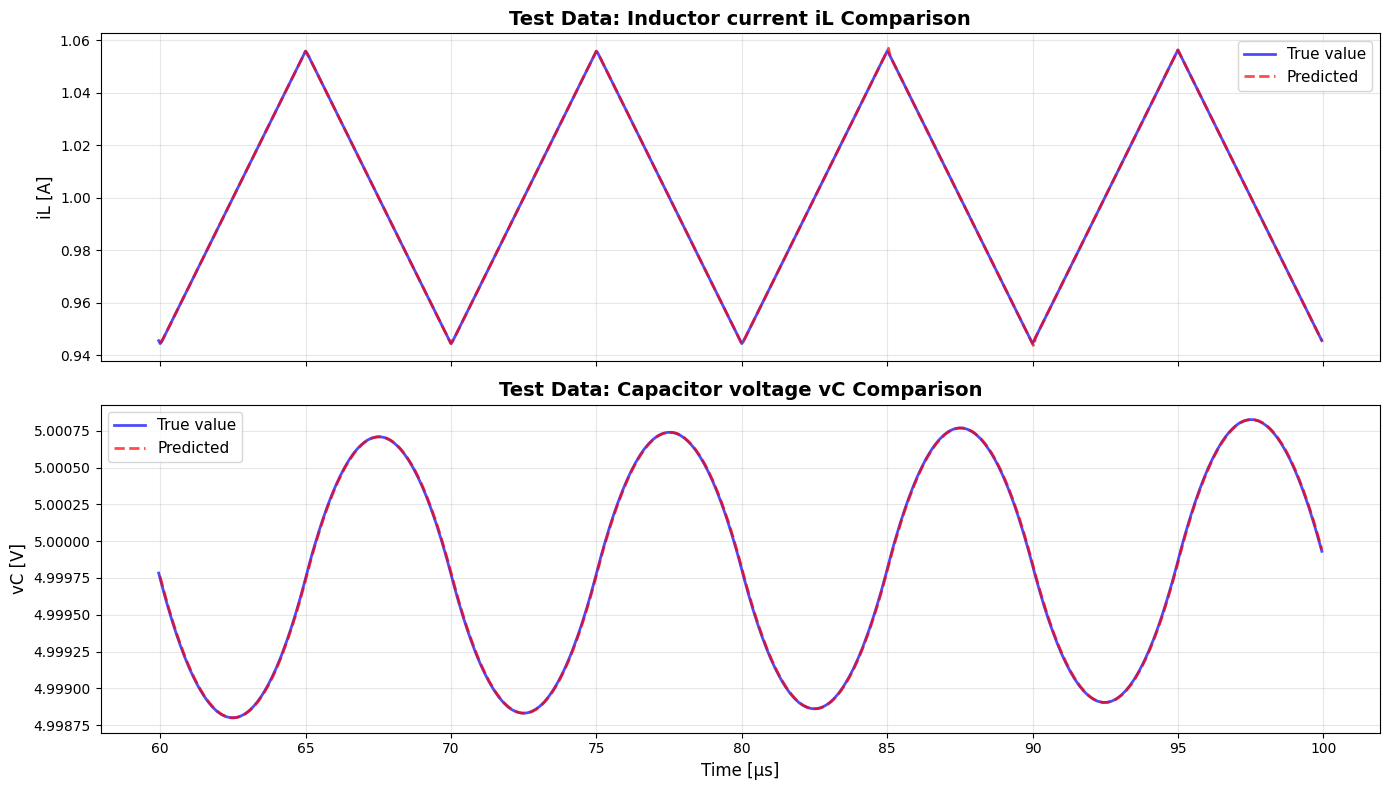

In [184]:
# テストデータでの予測結果を取得
model.eval()
with torch.no_grad():
    preds_test = model(h_test, x_test)

# 予測結果をnumpy配列に変換
preds_test_np = preds_test[:, :].cpu().detach().numpy()  # [n_test, 2]

# 予測値（iL, vC）
iL_test_pred = preds_test_np[:, 0]
vC_test_pred = preds_test_np[:, 1]

# グラフ表示
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iLの比較
axs[0].plot(
    t_test * 1e6,
    iL_test,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t_test[1:] * 1e6,
    iL_test_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].set_ylabel("iL [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor current iL Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vCの比較
axs[1].plot(
    t_test * 1e6,
    vC_test,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t_test[1:] * 1e6,
    vC_test_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].set_ylabel("vC [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor voltage vC Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
save_figure_to_log(fig, "test_prediction", result_dir, "テストデータでの予測結果")


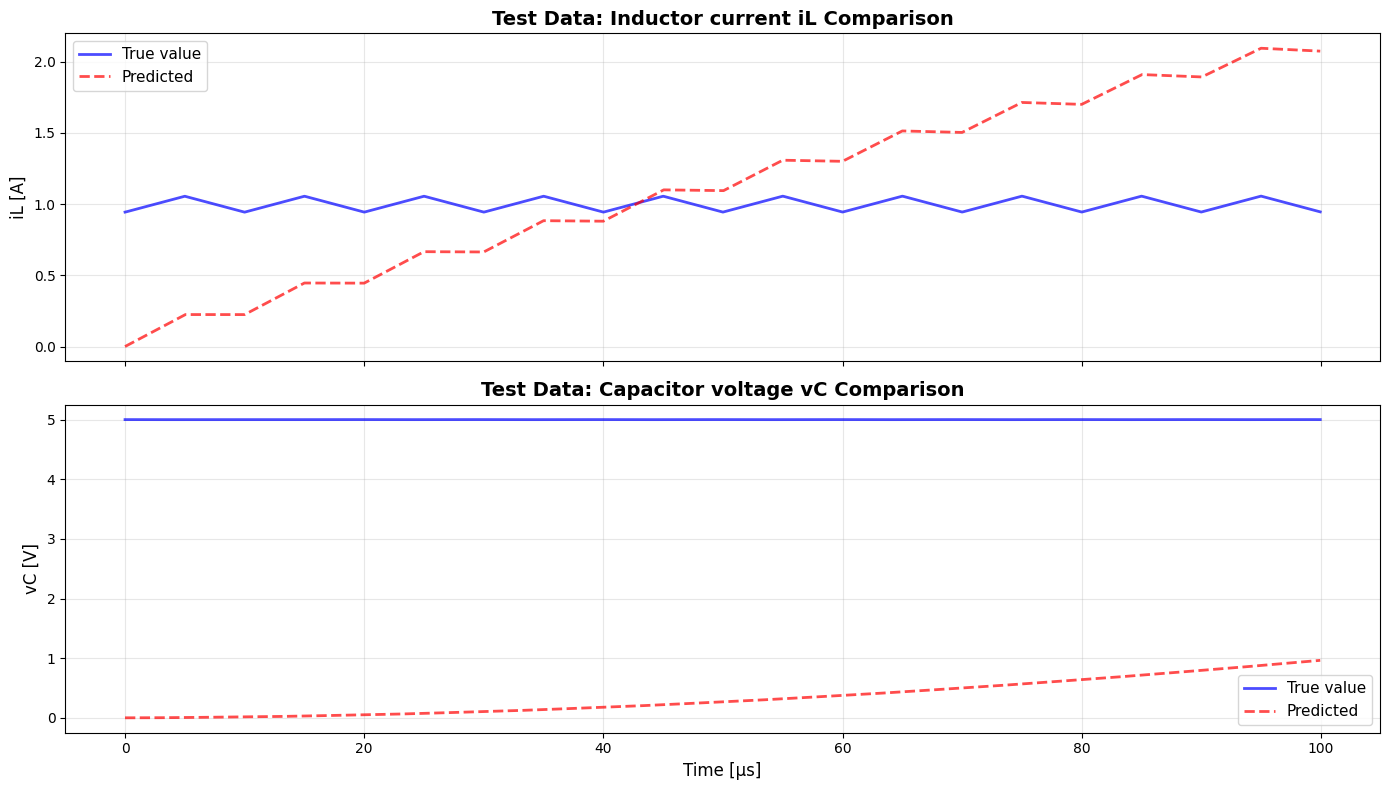

In [185]:
x_tensor = torch.tensor(np.c_[vs, u, dt], dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t) - 1):
        h_current = model(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C


iL_sim = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_sim = torch.tensor(np.array(vc_list), dtype=torch.float32)


# グラフ表示
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iLの比較
axs[0].plot(
    t * 1e6,
    iL,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t * 1e6,
    iL_sim,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].set_ylabel("iL [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor current iL Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vCの比較
axs[1].plot(
    t * 1e6,
    vC,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t * 1e6,
    vC_sim,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].set_ylabel("vC [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor voltage vC Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
save_figure_to_log(
    fig,
    "all_prediction",
    result_dir,
    "シミュレーション結果",
)
